In [166]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)


In [167]:
stores_2022 = pd.read_csv('/srv/data/my_shared_data_folder/rafi/2022_Business_Academic_QCQ_grocery.csv')
stores_2022.drop(['Unnamed: 0'],inplace=True,axis=1)
territories = ['PR', 'FM', 'MP', 'GU', 'VI', 'MH']
stores_2022 = stores_2022.drop(stores_2022[stores_2022['STATE'].isin(territories)].index)

stores_2022.head()
#stores_2022.info()

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE
0,GOMART,55 POSTAL PLZ,MORGANTOWN,WV,26508,7005.0,61.0,304,2,C,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,554110.0,ALTERNATIVE FUELS,NaN,NaN,NaN,NaN,NaN,NaN,2022,21303.0,13.0,2482.0,2,NaN,NaN,NaN,NaN,998372387,NaN,124929449.0,50.0,389500.0,E,I,998372387.0,NaN,7,11000.0,3.0,39.594376,-79.954437,P,34060.0,2.0,390.0,54061.0
1,7-ELEVEN,485 E MAIN ST,EL CENTRO,CA,92243,2619.0,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,W,NaN,NaN,NaN,495660326,NaN,5863311.0,800.0,1272634.0,H,K,495660326.0,NaN,7,11400.0,3.0,32.792679,-115.536058,0,20940.0,2.0,0.0,6025.0
2,EL SOL MARKET,110 W MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,5.0,1061.0,9,NaN,NaN,NaN,NaN,519605455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0
3,COOL SPRINGS GROCERY,241 WILDWOOD ST,MORGANTOWN,WV,26505,3141.0,61.0,304,2,A,A,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,2.0,382.0,9,NaN,NaN,NaN,NaN,817953730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,10400.0,4.0,39.652885,-79.986398,P,34060.0,2.0,390.0,54061.0
4,CIRCLE K,123 E MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,F,NaN,NaN,NaN,855113817,NaN,450720289.0,650.0,4981020.0,H,J,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0


In [143]:
states = stores_2022.groupby("STATE").count()['CITY']

In [150]:
stores_2022.shape

(202478, 53)

In [180]:
t10_22 = stores_2022.groupby('PARENT NUMBER', dropna=False).size().reset_index(name='COUNT')
t10_22.sort_values('COUNT', ascending=False, inplace=True)

# Create other row
other_row = t10_22.iloc[10:]
other_column = other_row['COUNT'].sum()

# Remove other rows
t10_22 = t10_22.iloc[:10]
t10_22.loc[len(t10_22)] = ["Other", other_column]

t10_22['PARENT NUMBER'] = t10_22['PARENT NUMBER'].astype(str)
t10_22['Percent'] = t10_22['COUNT'] / len(stores_2022) * 100
t10_22.COUNT.sum()

202478

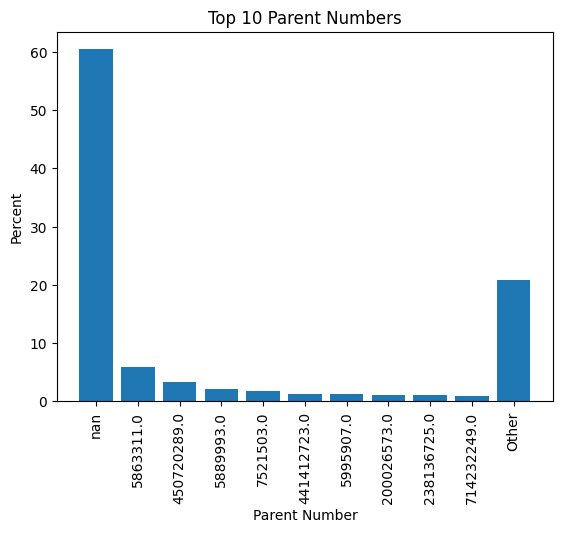

In [183]:
plt.bar(t10_22['PARENT NUMBER'], t10_22['Percent'])
plt.xlabel('Parent Number')
plt.ylabel('Percent')
plt.title('Top 10 Parent Numbers')
plt.xticks(rotation=90)
plt.show()


In [129]:
#stores_2022.loc[stores_2022.loc[:, "SIC6_DESCRIPTIONS (SIC)"]=="MARKETS & GROCERS EQUIP & SUPLS (WHLS)", "SIC CODE"]
stores_2022.loc[stores_2022.loc[:, "SIC6_DESCRIPTIONS (SIC)"]=="GROCERIES & RELATED PRODUCTS NEC (WHLS)", "SIC CODE"]

#s1.str.contains('og', regex=False)
#MARKETS & GROCERS EQUIP & SUPLS (WHLS)
#stores_2022["SIC6_DESCRIPTIONS (SIC)"].unique()[20:40]


236       514999.0
972       514999.0
1087      514999.0
1273      514999.0
1356      514999.0
            ...   
203187    514999.0
203274    514999.0
203356    514999.0
203428    514999.0
203443    514999.0
Name: SIC CODE, Length: 803, dtype: float64

In [189]:
#Filter Grocery stores by sic (starting with 411)
grocery_sic = stores_2022.loc[stores_2022[['PRIMARY SIC CODE', 'SIC CODE', 'SIC CODE 1', 'SIC CODE 2', 'SIC CODE 3', 'SIC CODE 4']].astype(str).apply(lambda x: x.str.startswith('5411')).any(axis=1)]
grocery_sic.head()

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE
0,GOMART,55 POSTAL PLZ,MORGANTOWN,WV,26508,7005.0,61.0,304,2,C,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,554110.0,ALTERNATIVE FUELS,NaN,NaN,NaN,NaN,NaN,NaN,2022,21303.0,13.0,2482.0,2,NaN,NaN,NaN,NaN,998372387,NaN,124929449.0,50.0,389500.0,E,I,998372387.0,NaN,7,11000.0,3.0,39.594376,-79.954437,P,34060.0,2.0,390.0,54061.0
1,7-ELEVEN,485 E MAIN ST,EL CENTRO,CA,92243,2619.0,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,W,NaN,NaN,NaN,495660326,NaN,5863311.0,800.0,1272634.0,H,K,495660326.0,NaN,7,11400.0,3.0,32.792679,-115.536058,0,20940.0,2.0,0.0,6025.0
2,EL SOL MARKET,110 W MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,5.0,1061.0,9,NaN,NaN,NaN,NaN,519605455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0
3,COOL SPRINGS GROCERY,241 WILDWOOD ST,MORGANTOWN,WV,26505,3141.0,61.0,304,2,A,A,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,2.0,382.0,9,NaN,NaN,NaN,NaN,817953730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,10400.0,4.0,39.652885,-79.986398,P,34060.0,2.0,390.0,54061.0
4,CIRCLE K,123 E MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,F,NaN,NaN,NaN,855113817,NaN,450720289.0,650.0,4981020.0,H,J,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0


In [190]:
grocery_t10_22 = grocery_sic.groupby('PARENT NUMBER', dropna=False).size().reset_index(name='COUNT')
grocery_t10_22.sort_values('COUNT', ascending=False, inplace=True)

# Create other row
other_row = grocery_t10_22.iloc[10:]
other_column = other_row['COUNT'].sum()

# Remove other rows
grocery_t10_22 = grocery_t10_22.iloc[:10]
grocery_t10_22.loc[len(grocery_t10_22)] = ["Other", other_column]

grocery_t10_22['PARENT NUMBER'] = grocery_t10_22['PARENT NUMBER'].astype(str)
grocery_t10_22['Percent'] = grocery_t10_22['COUNT'] / len(grocery_sic) * 100

grocery_t10_22


,PARENT NUMBER,COUNT,Percent
1067,nan,77818,49.287773
78,5863311.0,11939,7.561833
585,450720289.0,6814,4.315799
81,5889993.0,4397,2.784938
92,7521503.0,3574,2.263673
574,441412723.0,2499,1.582798
84,5995907.0,2493,1.578997
263,200026573.0,2217,1.404187
281,238136725.0,2105,1.333249
843,714232249.0,1760,1.114735


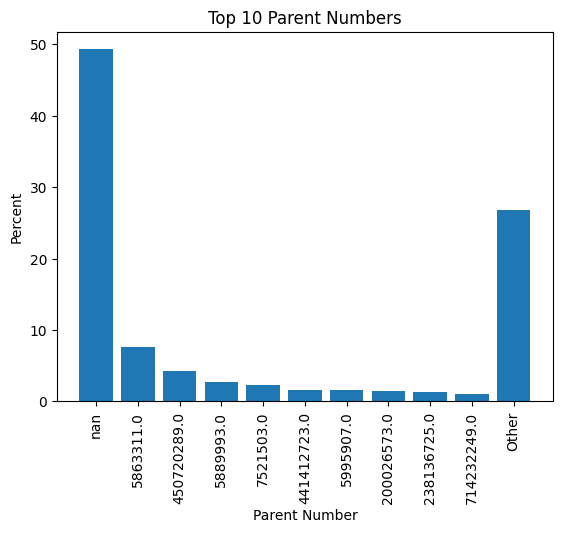

In [191]:
#Grocery bar?
plt.bar(grocery_t10_22['PARENT NUMBER'], grocery_t10_22['Percent'])
plt.xlabel('Parent Number')
plt.ylabel('Percent')
plt.title('Top 10 Parent Numbers')
plt.xticks(rotation=90)
plt.show()